In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import numpy as np
from scipy.stats import norm
import pandas as pd
sns.set()

In [2]:
#Black Scholes function
def BlackScholes(price, eXprice, ifree, iDate, fDate, vol, div):
    
    #divide by 100 to make decimals instead of percentajes
    ifree, vol, div = ifree/100, vol/100, div/100 

    # expected life of option in years. I do not know why 360 is used, but
    # sticking with tradition...
    timeExp = (fDate - iDate).days/360
    
    #d1 and d2
    d1 = (np.log(price/eXprice)+timeExp*(ifree-div+(vol**2)/2))/(vol*np.sqrt(timeExp))
    d2 = (np.log(price/eXprice)+timeExp*(ifree-div-(vol**2)/2))/(vol*np.sqrt(timeExp))
    #d2 = d1-vol*np.sqrt(timeExp)

    #calls and puts prices
    call =   price*np.exp(-div*timeExp)*norm.cdf( d1, 0, 1)  - eXprice*np.exp(-ifree*timeExp)*norm.cdf( d2, 0, 1)
    put  = eXprice*np.exp(-ifree*timeExp)*norm.cdf(-d2, 0, 1)- price*np.exp(-div*timeExp)*norm.cdf(-d1, 0, 1) 
    
    return call, put


In [3]:
# miscelaneous inputs, if percentages no percentage sign
ifree    = 2.42                        # interest rate %
div      = 1.78                        # dividends %
precio   = 281.52                      # stock price at initial date

#allowed price change up and down, like 0.1 = 10%
deltaPrecio = 0.20
precioAlto = precio * (1 + deltaPrecio)
precioBajo = precio * (1 - deltaPrecio)

#Plotting parameters
#how many days and price divisions
subDays   = 10
subPrices = 5

#array of prices
precios = (np.arange(precioBajo, precioAlto, subPrices, dtype = 'int64')).tolist()

#array of prices for plotting
pBajo = [precioBajo ]* len(precios)
pAlto = [precioAlto] * len(precios)

#time data
iDate   = datetime.date(2019, 6, 5)   # initial date (year, month, day)
fDate   = datetime.date(2020, 6, 19)   # final or excercise date
dias    = (np.arange(iDate, fDate, subDays, dtype = 'datetime64[D]')).tolist() # array of days

In [4]:
# specific Option 1 data
exPrecio1 = 280                          # excercise price
vol1     = 16.10                         # volatility %
pagado1  = True                          # True if option is bought (net debit), False if sold or written (net credit)
opPrecio1 = 19.15                        # price of option
esCall1   = True                         # True if CALL, False if PUT
nOpt1   = 1                              # number of options

In [5]:
# specific Option 2 data
exPrecio2 = 285                          # excercise price
vol2     = 15.52                         # volatility %
pagado2  = True                          # True if option is bought (net debit), False if sold or written (net credit)
opPrecio2 = 19.75                        # price of option
esCall2   = False                        # True if CALL, False if PUT
nOpt2     = 1                            # number of options

In [6]:
# Option 1 dataframe
prismaColor1 = np.zeros(shape=(len(precios), len(dias)))
df1 = pd.DataFrame(prismaColor1, columns = dias, index = precios)  

for j in range(len(precios)):
    for i in range(len(dias)):
        call, put = BlackScholes(precios[j], exPrecio1, ifree, dias[i], fDate, vol1, div)
        if esCall1:
            opcionazo = call
        else:
            opcionazo = put
        if pagado1: 
            df1.iloc[j, i] = opcionazo - opPrecio1
        else:
            df1.iloc[j, i] = opPrecio1 - opcionazo
            
df1 = df1*nOpt1*100

In [7]:
# Option 2 dataframe
prismaColor2 = np.zeros(shape=(len(precios), len(dias)))
df2 = pd.DataFrame(prismaColor2, columns = dias, index = precios)  

for j in range(len(precios)):
    for i in range(len(dias)):
        call, put = BlackScholes(precios[j], exPrecio2, ifree, dias[i], fDate, vol2, div)
        if esCall2:
            opcionazo = call
        else:
            opcionazo = put
        if pagado2: 
            df2.iloc[j, i] = opcionazo - opPrecio2
        else:
            df2.iloc[j, i] = opPrecio2 - opcionazo
            
df2 = df2*nOpt2*100

In [8]:
# Combine options and plot

combinado = df1 + df2

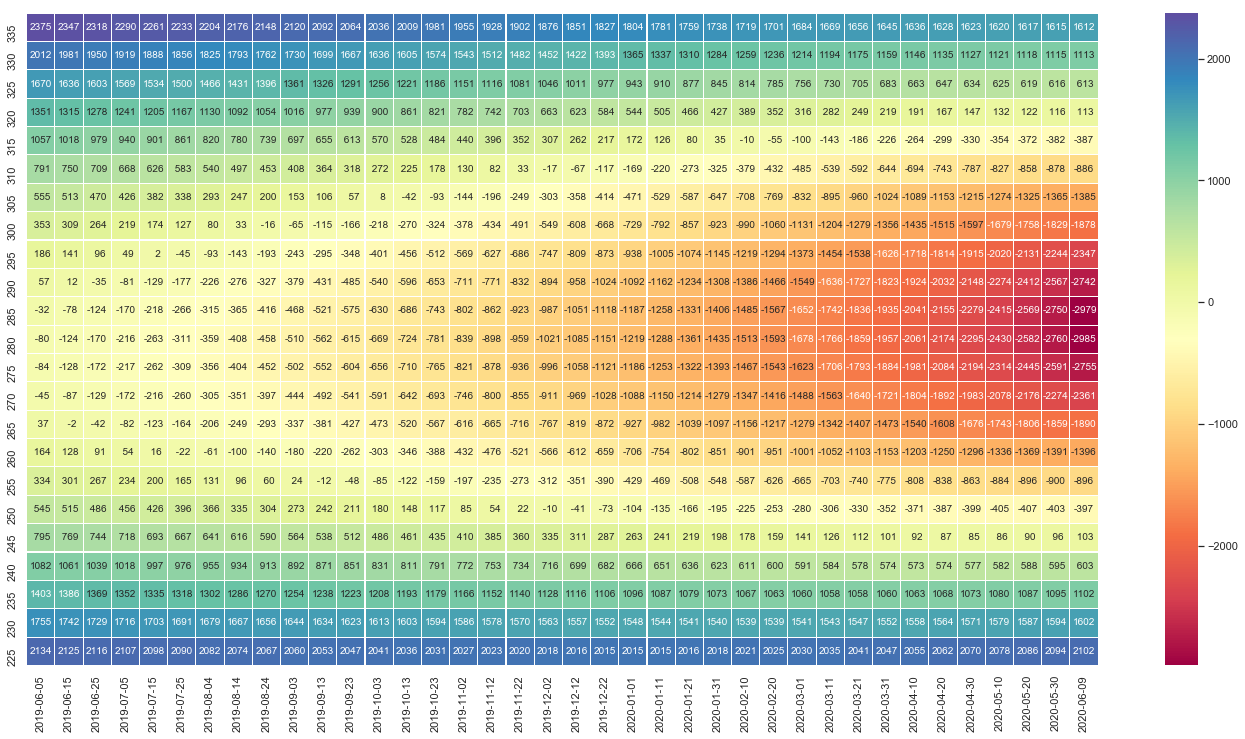

<Figure size 432x288 with 0 Axes>

In [9]:
f, ax = plt.subplots(figsize=(24, 12))
figurita = sns.heatmap(combinado, annot = True, fmt = '4.0f', linewidths = .1, ax = ax, cmap = 'Spectral')
ax.invert_yaxis()
plt.savefig('spectral.png', dpi = 100)
plt.figure()
plt.show()

In [10]:
#print to help set up scales
print('min ', min(combinado.min()), ' max ', max(combinado.max()))

min  -2984.8713755429253  max  2375.076619321104


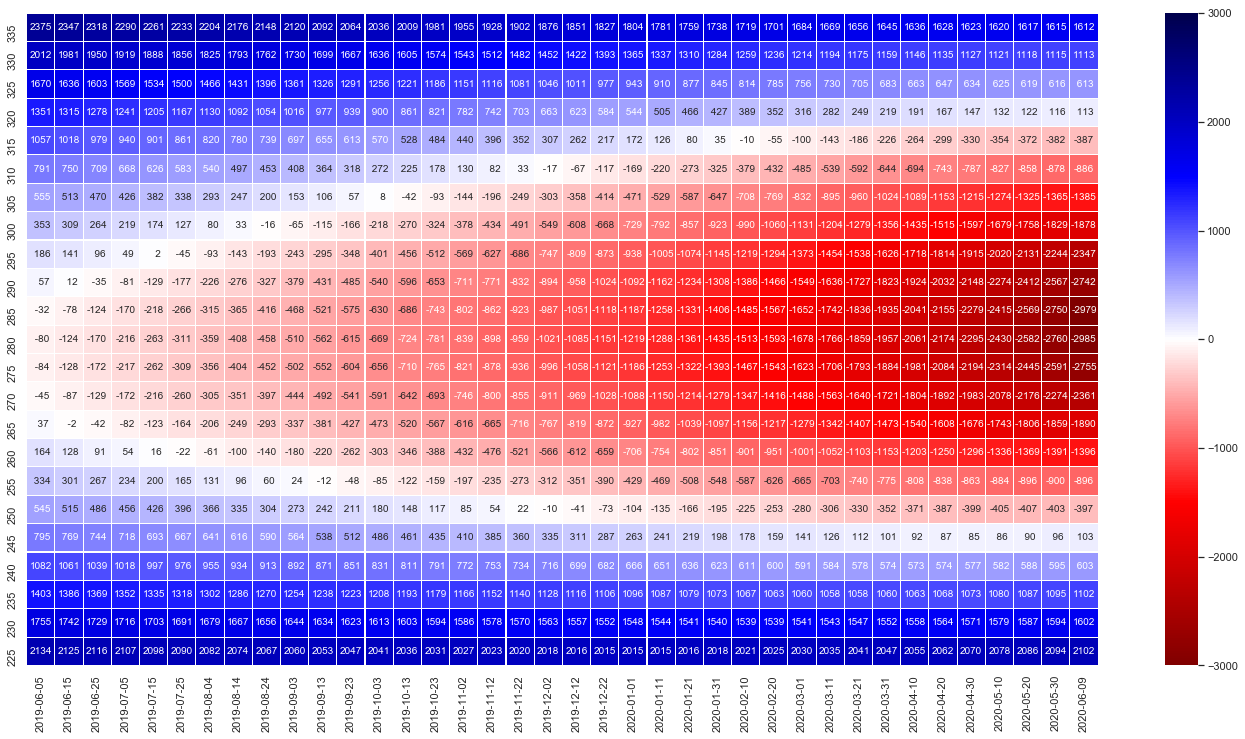

<Figure size 432x288 with 0 Axes>

In [11]:
level_min = -3000
level_max =  3000

f, ax = plt.subplots(figsize=(24, 12))
figurita = sns.heatmap(combinado, annot = True, fmt = '4.0f', linewidths = .1, 
                       ax = ax, cmap = 'seismic_r', vmin = level_min, vmax = level_max)
ax.invert_yaxis()
plt.savefig('grid.png', dpi = 100)
plt.figure()
plt.show()

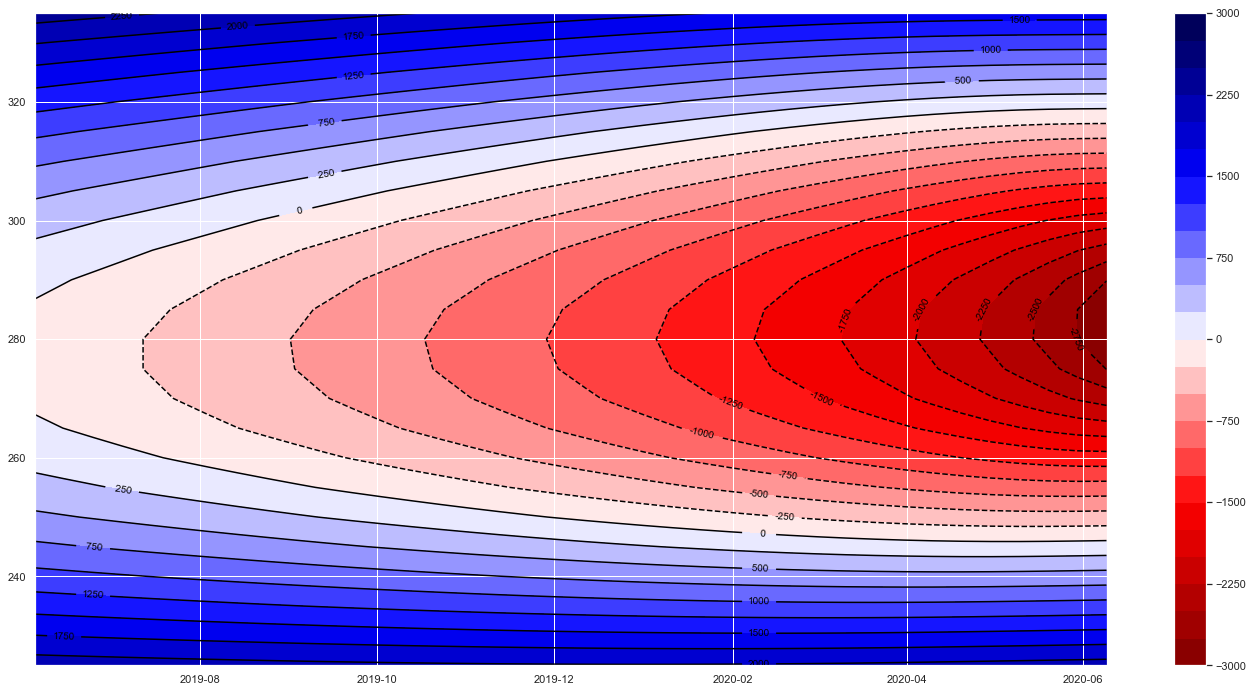

In [12]:
#contour plot, for fun
# https://matplotlib.org/users/colormaps.html
# recommended: spectral, magma, seismic_r, viridis, BrBG 

import matplotlib as mpl
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#density plot
X,Y = np.meshgrid(combinado.index, combinado.columns)
nbins = 24
levels = mpl.ticker.MaxNLocator(nbins=nbins).tick_values(level_min, level_max)
plt.figure(figsize=(24, 12))
plt.contourf(combinado.columns, combinado.index, combinado, levels = levels,
             zorder = 0, cmap = 'seismic_r' )
plt.colorbar()

#plot contour lines
#to get the right number of them, level_min and level_max had to be multiples of division
division = 250
niveles = np.arange(level_min, level_max, division)
contornos = plt.contour(combinado.columns, combinado.index, combinado, levels = niveles, 
                        colors = 'black')
plt.clabel(contornos, inline = 1, fontsize = 10, fmt = '%4.0f')
plt.savefig('contour.png', dpi = 100)